<a href="https://colab.research.google.com/github/usshaa/Cheatsheets/blob/main/Langraph_Agent_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 14.8 MB/s eta 0:00:00


## Graph I

In [2]:
from typing import Dict, TypedDict
from langgraph.graph import StateGraph

In [3]:
class AgentState(TypedDict):
  message : str


In [4]:
def greeting_node(state: AgentState) -> AgentState:
  """Simple node that adds a greeting message to the state"""

  state['message'] = "Hey "+ state["message"] + ", how is your day going?"
  return state

In [5]:
graph = StateGraph(AgentState)

graph.add_node("greeter", greeting_node)
graph.set_entry_point("greeter")
graph.set_finish_point("greeter")

app = graph.compile()

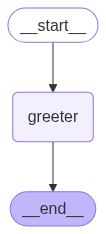

In [6]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [7]:
result = app.invoke({"message":"Bob"})

In [8]:
result['message']

'Hey Bob, how is your day going?'

## GRAPH II

In [9]:
from typing import TypedDict, List
from langgraph.graph import StateGraph

In [10]:
class AgentState(TypedDict):
  values: List[int]
  name: str
  result: str

In [12]:
def process_values(state: AgentState) -> AgentState:
  """This function handles multiple different inputs"""
  print(state)

  state["result"] = f"Hi there {state['name']}! Your sum = {sum(state['values'])}"

  print(state)
  return state

In [13]:
graph = StateGraph(AgentState)

graph.add_node("processor", process_values)

graph.set_entry_point("processor")
graph.set_finish_point("processor")

app = graph.compile()

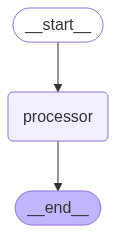

In [14]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [15]:
answers = app.invoke({"values":[1,2,3,4], "name": "Usha"})

{'values': [1, 2, 3, 4], 'name': 'Usha'}
{'values': [1, 2, 3, 4], 'name': 'Usha', 'result': 'Hi there Usha! Your sum = 10'}


In [16]:
print(answers["result"])

Hi there Usha! Your sum = 10


## GRAPH III

In [17]:
from typing import TypedDict
from langgraph.graph import StateGraph

In [18]:
class AgentState(TypedDict):
  name : str
  age : str
  final : str

In [19]:
def first_node(state: AgentState) -> AgentState:
  """This is the first node of our sequence"""

  state["final"] = f'{state["name"]}'

  return state

def second_node(state: AgentState) -> AgentState:
  """This is the second node of our sequence"""

  state["final"] = state["final"] + f' You are {state["age"]} years old!'

  return state

In [20]:
graph = StateGraph(AgentState)
graph.add_node("first_node", first_node)
graph.add_node("second_node", second_node)

graph.set_entry_point("first_node")
graph.add_edge("first_node", "second_node")
graph.set_finish_point("second_node")

app = graph.compile()

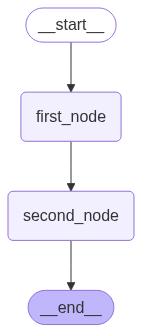

In [21]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [22]:
result = app.invoke({"name": "usha", "age" : 20})
print(result)

{'name': 'usha', 'age': 20, 'final': 'usha You are 20 years old!'}


In [23]:
result['final']

'usha You are 20 years old!'

## GRAPH IV

In [24]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

In [25]:
class AgentState(TypedDict):
  number1: int
  operation: str
  number2: int
  finalNumber: int

In [26]:
def adder(state:AgentState) -> AgentState:
  """This node adds 2 numbers"""
  state["finalNumber"] = state["number1"] + state["number2"]

  return state

def subtractor(state:AgentState) -> AgentState:
  """This node subtracts 2 numbers"""
  state["finalNumber"] = state["number1"] - state["number2"]

  return state

def decide_next_node(state:AgentState) -> AgentState:
  """This node will select the next node for the graph"""

  if state["operation"] == "+":
    return "addition_operation"

  elif state["operation"] == "-":
    return "subtraction_operation"

In [27]:
graph = StateGraph(AgentState)

graph.add_node("add_node", adder)
graph.add_node("subtract_node", subtractor)
graph.add_node("router", lambda state:state)

graph.add_edge(START, "router")

graph.add_conditional_edges(
    "router",
    decide_next_node,
    {
        "addition_operation": "add_node",
        "subtraction_operation": "subtract_node"
    }
)

graph.add_edge("add_node", END)
graph.add_edge("subtract_node", END)

app = graph.compile()

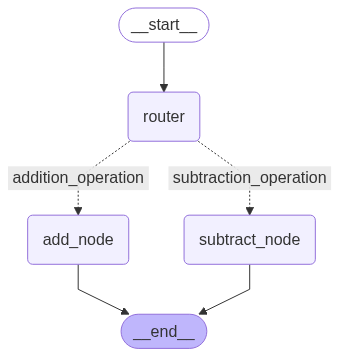

In [28]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [30]:
initial_state1 = AgentState(number1=10, operation="-", number2=5)
print(app.invoke(initial_state1))

{'number1': 10, 'operation': '-', 'number2': 5, 'finalNumber': 5}


## GRAPH V

In [31]:
from langgraph.graph import StateGraph, END
import random
from typing import Dict, List, TypedDict

In [32]:
class AgentState(TypedDict):
  name: str
  number: List[int]
  counter: int

In [33]:
def greeting_node(state: AgentState) -> AgentState:
  """Greeting Node which says hi to the person"""

  state['name'] = f"Hi there, {state['name']}"
  state["counter"] = 0

  return state

def random_node(state: AgentState) -> AgentState:
  """Generates a random number from 0 to 10"""
  state["number"].append(random.randint(0,10))
  state["counter"] += 1

  return state

def should_continue(state: AgentState) -> AgentState:
  """Function to decide what to do next"""
  if state["counter"] < 5:
    print("ENTERING LOOP", state["counter"])
    return "loop"
  else:
    return "exit"

In [ ]:
# greeting -> random -> random -> random -> random -> random -> END"

In [34]:
graph = StateGraph(AgentState)

graph.add_node("greeting", greeting_node)
graph.add_node("random", random_node)
graph.add_edge("greeting", "random")

graph.add_conditional_edges(
    "random",
    should_continue,
    {
        "loop": "random",
        "exit": END
    }
)

graph.set_entry_point("greeting")

app = graph.compile()

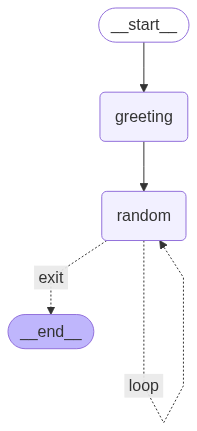

In [35]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [36]:
app.invoke({"name":"Usha", "number": [], "counter":-1})

ENTERING LOOP 1
ENTERING LOOP 2
ENTERING LOOP 3
ENTERING LOOP 4


{'name': 'Hi there, Usha', 'number': [8, 9, 3, 3, 3], 'counter': 5}

## AGENT I

In [37]:
!pip install langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 3.4 MB/s eta 0:00:00


In [38]:
!pip install dotenv

In [40]:
load_dotenv()

False

In [41]:
# Install the necessary library for Gemini
!pip install langchain-google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 36.8 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


In [4]:
from typing import TypedDict, List
from langchain_core.messages import HumanMessageChunk
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv

In [5]:
from typing import TypedDict, List
from langchain_core.messages import HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI # Import Gemini
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv
from google.colab import userdata # Import userdata to access secrets

In [6]:
# Get your Google API key from Colab secrets
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
if not GOOGLE_API_KEY:
  raise ValueError("Please set your GOOGLE_API_KEY in Colab Secrets")

# Initialize the Gemini model
# Choose a model that supports chat, e.g., 'gemini-1.5-flash-latest' or 'gemini-1.5-pro-latest'
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest", google_api_key=GOOGLE_API_KEY)

In [7]:
class AgentState(TypedDict):
  messages: List[HumanMessageChunk]
  name: str

def process(state: AgentState) -> AgentState:
  response = llm.invoke(state["messages"])
  print(f"\nAI: {response.content}")
  return state


In [8]:
graph = StateGraph(AgentState)
graph.add_node("process", process)
graph.add_edge(START, "process")
graph.add_edge("process", END)
agent = graph.compile()

In [9]:
user_input = input("Enter : ")
while user_input != "exit":
  agent.invoke({'messages':[HumanMessage(content=user_input)]})
  user_input = input("Enter : ")

Enter : Hi

AI: Hi there! How can I help you today?
Enter : Langraph

AI: There's no established meaning or known entity called "Langraph."  It's likely a neologism (a newly coined word or expression) or a misspelling.

To help me understand what you're looking for, could you please provide more context?  For example:

* **Did you mean a specific word?**  Perhaps you misspelled something similar.
* **Is it a technical term?**  If so, from what field? (e.g., linguistics, computer science, graph theory)
* **Is it a brand name or product name?**
* **Where did you encounter this term?**

With more information, I can offer a more helpful response.
Enter : What is Langgraph?

AI: LangGraph is a large-scale knowledge graph built from various sources of textual information, primarily focusing on language-related knowledge.  It doesn't represent a single, monolithic project but rather a concept and potentially multiple implementations.  The key idea is to represent linguistic information—words,

## AGENT II

In [10]:
from typing import TypedDict, List, Union
from langchain_core.messages import HumanMessage, AIMessage
from langchain_google_genai import ChatGoogleGenerativeAI # Import Gemini
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv
from google.colab import userdata # Import userdata to access secrets

In [12]:
class AgentState(TypedDict):
  messages: List[Union[HumanMessage, AIMessage]]

def process(state: AgentState) -> AgentState:
  """This node will solve the request you input"""
  response = llm.invoke(state["messages"])

  state["messages"].append(AIMessage(content=response.content))
  print(f"\nAI: {response.content}")
  print(f"CURRENT STATE: ", state["messages"])

  return state

In [13]:
graph = StateGraph(AgentState)
graph.add_node("process", process)
graph.add_edge(START, "process")
graph.add_edge("process", END)
agent = graph.compile()

In [15]:
conversation_history = []

user_input = input("Enter : ")
while user_input != "exit":
  conversation_history.append(HumanMessage(content=user_input))
  result = agent.invoke({'messages':conversation_history})
  conversation_history = result["messages"]
  user_input = input("Enter : ")

with open("logging.txt","w") as file:
  file.write("Your Conversation Log: \n")

  for message in conversation_history:
    if isinstance(message, HumanMessage):
      file.write(f"You: {message.content}\n")
    elif isinstance(message, AIMessage):
      file.write(f"AI: {message.content}\n")
  file.write("End of Conversation")

print("Conversation saved to logging.txt")

Enter : exit
Conversation saved to logging.txt


## AGENT III

#### REACT Agent

In [16]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langchain_core.messages import ToolMessage
from langchain_core.messages import SystemMessage
from langchain_google_genai import ChatGoogleGenerativeAI # Import Gemini
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from dotenv import load_dotenv
from google.colab import userdata # Import userdata to access secrets

In [18]:
email = Annotated[str, "This has to be valid email format"]
print(email.__metadata__)

('This has to be valid email format',)


In [20]:
# without a reducer
state = {"messages":["Hi!"]}
update = {"messages":["Nice to meet you!"]}
new_state = {"messages":["Nice to meet you!"]}

In [21]:
# with a reducer
state = {"messages":["Hi!"]}
update = {"messages":["Nice to meet you!"]}
new_state = {"messages":["Hi","Nice to meet you!"]}